In [3]:
import string
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

In [36]:
df = pd.read_csv("../data/clean_technology_reviews.csv", index_col=0)

In [37]:
df.drop("summary", axis=1, inplace=True)

In [38]:
df

,overall,reviewText
0,5.0,Looks even better in person. Be careful to not...
1,5.0,When you don't want to spend a whole lot of ca...
2,3.0,"so the case came on time, i love the design. I..."
3,2.0,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...
4,4.0,"I liked it because it was cute, but the studs ..."
...,...,...
1128429,4.0,Very good cell phone holster. Keeps my phone ...
1128430,1.0,Mediocre case protection. Clip is junk. Broke/...
1128431,3.0,my sons likes it. For the price it isn't too bad
1128432,4.0,Good for viewing. But doesn't have a button or...


In [39]:
pd.DataFrame(np.unique(df['overall'], return_counts=True)).T.set_index(0)

,1
0,
1.0,73720.0
2.0,51444.0
3.0,87877.0
4.0,157761.0
5.0,615363.0


In [40]:
rev_len = list()
for review in df["reviewText"]:
    rev_len.append(len(str(review)))

In [41]:
df["length"] = rev_len

In [42]:
df["length"].describe()

count    986165.000000
mean        209.004143
std         363.109524
min           1.000000
25%          34.000000
50%         108.000000
75%         240.000000
max       33457.000000
Name: length, dtype: float64

In [57]:
shorter = df[df["length"]<=500].copy()


In [58]:
shorter["reviewText"].fillna("", inplace=True)

In [59]:
shorter = shorter.reset_index(drop='index')

In [60]:
shorter["binary"]= np.where(shorter['overall']>3, 1, 0)

In [61]:
shorter.head(10)

,overall,reviewText,length,binary
0,5.0,Looks even better in person. Be careful to not...,271,1
1,5.0,When you don't want to spend a whole lot of ca...,102,1
2,3.0,"so the case came on time, i love the design. I...",257,0
3,2.0,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,92,0
4,4.0,"I liked it because it was cute, but the studs ...",150,1
5,2.0,The product looked exactly like the picture an...,159,0
6,3.0,I FINALLY got my case today. It took forever t...,344,0
7,5.0,It is a very cute case. None of the jewels hav...,327,1
8,1.0,DO NOT BUY! this item is seriously cheap as he...,190,0
9,4.0,I really love this case... you have to keep yo...,188,1


In [62]:

X_1 = shorter["reviewText"].copy()
y_1= shorter["binary"]


X_rem, X_test, y_rem, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

In [63]:
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.2, random_state=42)

In [64]:
stop_words = stopwords.words('english')

In [65]:
X_train

501427    This product is great but I have this minor ch...
20742     This item came quickly and was well packaged. ...
564515    The case is cool, it's slightly smaller than t...
294791                                           thank  you
264445    Fits my new Apple Air perfectly.....  Can take...
                                ...                        
197979                                                great
607057    I wasn't a fan of this case. It wasn't as ligh...
890331    Very slim and soft.  It fits easy in my pocket...
318267    Very nice cover and it has saved my phone a co...
404924               great protector for my Sony Xperia Z3.
Name: reviewText, Length: 569884, dtype: object

In [66]:
def my_tokenizer(document):

    # remove punctuation
    for punct in string.punctuation:
        document=document.replace(punct,'')

    # tokenize - split on whitespace
    tokenized_document = document.split(' ')

    # pattern denoting a sequence of at least 2 alphanumeric characters
    pattern=r"(?u)\b\w\w+\b"

        # tokenize - split by matching a pattern
    tokenized_document = re.findall(pattern, document)
    
    # remove stopwords before stemming or lemmatization
    tokenized_document = [word for word in tokenized_document if word not in stop_words]


    stemmed_tokens_list = []
    for i in tokenized_document:
        token = PorterStemmer().stem(i)
        stemmed_tokens_list.append(token)
    return stemmed_tokens_list


In [67]:
tfidf = TfidfVectorizer(min_df=10,tokenizer = my_tokenizer,max_features=500)
tfidf.fit(X_train)
X_train_transformed = tfidf.transform(X_train)
X_val_transformed = tfidf.transform(X_val)

/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [68]:
nltk.download('words')

[nltk_data] Downloading package words to /Users/edo/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [69]:
word_counts = pd.DataFrame(
    {"counts": X_train_transformed.toarray().sum(axis=0)},
    index=tfidf.get_feature_names_out()
).sort_values("counts", ascending=False)

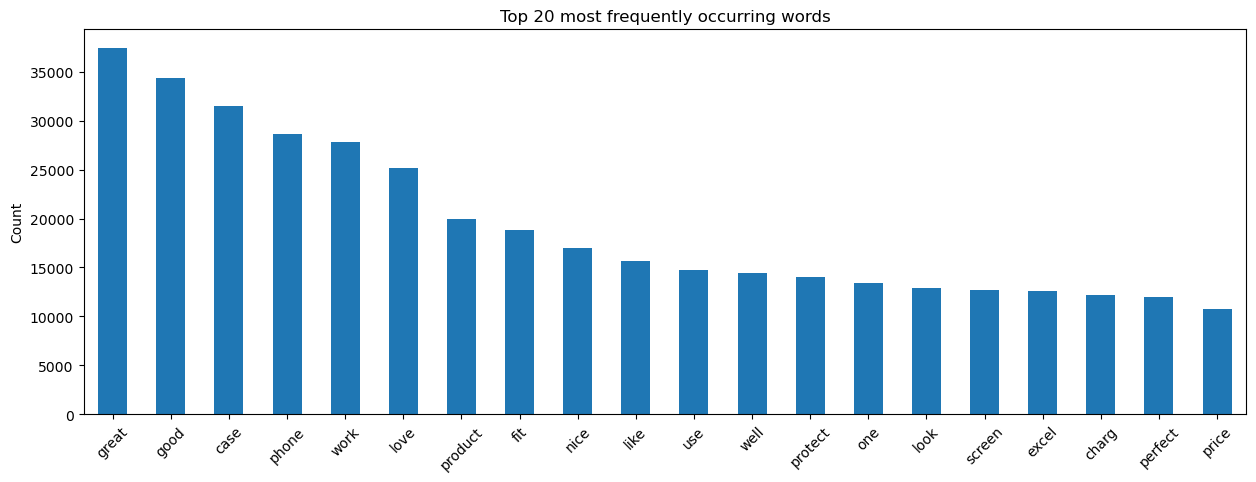

In [70]:
word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [71]:
feat = tfidf.get_feature_names_out()

In [72]:
english_words = set(nltk.corpus.words.words())
unrecognized_tokens = [token for token in feat if token.lower() not in english_words]
num_unrec = len(unrecognized_tokens)
num_unrec/len(feat)

0.272

In [73]:
review_vectors = tfidf.transform(shorter["reviewText"].fillna(''))


In [74]:
review_vectors_df = pd.DataFrame(review_vectors.toarray(), columns=tfidf.get_feature_names_out())


In [75]:
output_df = pd.concat([shorter, review_vectors_df], axis=1)

In [76]:
output_df.head(3)

,overall,reviewText,length,binary,10,100,6s,abl,absolut,access,...,wont,work,worri,worth,would,wouldnt,wrong,year,yet,your
0,5.0,Looks even better in person. Be careful to not...,271,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,5.0,When you don't want to spend a whole lot of ca...,102,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,3.0,"so the case came on time, i love the design. I...",257,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.206292,0.0


In [77]:
output_df.to_pickle("../data/reviews_vector.pkl")